In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh


def doa_phase(received_signals):
    z1, z2 = received_signals[1, 0], received_signals[2, 0]
    theta1 = np.angle(z1) 
    theta2 = np.angle(z2)

    # print(np.arctan(np.imag(z1) / np.real(z1)))
    # print(np.arctan(np.imag(z2) / np.real(z2)))
    # print(f"Phase of z1: {theta1} radians")
    # print(f"Phase of z2: {theta2} radians")

    # 计算相位差
    phase_difference = theta2 - theta1
    phase_difference = np.angle(np.exp(1j * phase_difference))  # 规范到 -π 到 π 范围内

    # phi_ = (2*pi) / lambda * (d*sin(theta))
    # so, theta = phi_ * lambda / (2*pi) / d
    # theta_ = np.arcsin( phase_difference * waveL / (2*np.pi) / d) / np.pi * 180
    theta_ = np.arcsin( phase_difference / np.pi) / np.pi * 180
        
    return theta_


def doa_fft(received_signals, fft_num):
    search_angles = np.linspace(-90, 90, fft_num)
    fft_data = np.abs(np.fft.fftshift(np.fft.fft(received_signals, fft_num)))
    fft_spectrum = 10 * np.log10(fft_data / np.max(fft_data))
    
    return search_angles, fft_spectrum

# using MUSIC
def music_algorithm(received_signals, num_sources, num_antennas, n):
    """ MUSIC算法实现 """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    
    # 特征值分解
    eigenvalues, eigenvectors = np.linalg.eigh(R)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 噪声子空间
    noise_subspace = eigenvectors[:, num_sources:]
    
    # 搜索角度
    search_angles = np.linspace(-90, 90, n)
    search_rad = np.deg2rad(search_angles)
    music_spectrum = np.zeros(search_angles.shape)
    
    for i, angle in enumerate(search_rad):
        steering_vector = np.exp(2j * np.pi * 0.5 * np.arange(num_antennas) * np.sin(angle))
        music_spectrum[i] = 1 / np.abs(steering_vector.conj().T @ noise_subspace @ noise_subspace.conj().T @ steering_vector)
    
    music_spectrum = 10 * np.log10(music_spectrum)  # 转换为dB
    return search_angles, music_spectrum


def doa_music(received_signals, nsig, n, spacing=0.5):
    """
    Estimate arrival directions of signals using MUSIC for a uniform linear
    array (ULA)

    :param numpy.2darray covmat:
        Sensor covariance matrix, specified as a complex-valued, positive-
        definite M-by-M matrix. The quantity M is the number of elements
        in the ULA array
    :param int nsig:
        Number of arriving signals, specified as a positive integer. The
        number of signals must be smaller than the number of elements in
        the ULA array
    :param float spacing:
        Distance (wavelength) between array elements. ``default 0.5``
    :param numpy.1darray scanangles:
        Broadside search angles, specified as a real-valued vector in degrees.
        Angles must lie in the range [-90°,90°] and must be in increasing
        order. ``default [-90°,90°] ``

    :return: doa angles in degrees, doa index, pseudo spectrum (dB)
    :rtype: list, list, numpy.1darray
    """
    # 计算协方差矩阵
    covmat = received_signals @ received_signals.conj().T
    covmat /= np.trace(covmat)
    
    n_array = np.shape(covmat)[0]
    array = np.linspace(0, (n_array - 1) * spacing, n_array)
    scanangles = np.linspace(-90, 90, n)

    # `eigh` guarantees the eigen values are sorted
    _, eig_vects = np.linalg.eigh(covmat)
    noise_subspace = eig_vects[:, :-nsig]

    array_grid, angle_grid = np.meshgrid(array, np.radians(scanangles), indexing="ij")
    steering_vect = np.exp(1j * 2 * np.pi * array_grid * np.sin(angle_grid)) / np.sqrt(n_array)

    pseudo_spectrum = 1 / np.linalg.norm((noise_subspace.T.conj() @ steering_vect), axis=0)

    ps_db = 10 * np.log10(pseudo_spectrum / pseudo_spectrum.max())

    return scanangles, ps_db


def doa_root_music(received_signals, nsig, spacing=0.5):
    """
    Estimate arrival directions of signals using root-MUSIC for a uniform
    linear array (ULA)

    :param numpy.2darray covmat:
        Sensor covariance matrix, specified as a complex-valued, positive-
        definite M-by-M matrix. The quantity M is the number of elements
        in the ULA array
    :param int nsig:
        Number of arriving signals, specified as a positive integer. The
        number of signals must be smaller than the number of elements in
        the ULA array
    :param float spacing:
        Distance (wavelength) between array elements. ``default 0.5``

    :return: doa angles in degrees
    :rtype: list
    """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    n_covmat = np.shape(R)[0]

    _, eig_vects = np.linalg.eigh(R)
    noise_subspace = eig_vects[:, :-nsig]

    # Compute the coefficients for the polynomial.
    noise_mat = noise_subspace @ noise_subspace.T.conj()
    coeff = np.zeros((n_covmat - 1,), dtype=np.complex_)
    for i in range(1, n_covmat):
        coeff[i - 1] = np.trace(noise_mat, i)
    coeff = np.hstack((coeff[::-1], np.trace(noise_mat), coeff.conj()))

    roots = np.roots(coeff)

    # Find k points inside the unit circle that are also closest to the unit
    # circle.
    mask = np.abs(roots) <= 1
    # On the unit circle. Need to find the closest point and remove it.
    for _, i in enumerate(np.where(np.abs(roots) == 1)[0]):
        mask_idx = np.argsort(np.abs(roots - roots[i]))[1]
        mask[mask_idx] = False

    roots = roots[mask]
    sorted_indices = np.argsort(1.0 - np.abs(roots))
    sin_vals = np.angle(roots[sorted_indices[:nsig]]) / (2 * np.pi * spacing)

    return np.degrees(np.arcsin(sin_vals))

def doa_capon(received_signals, spacing=0.5, n=90):
    """
    Capon (MVDR) beamforming for a uniform linear array (ULA)

    :param numpy.2darray covmat:
        Sensor covariance matrix, specified as a complex-valued, positive-
        definite M-by-M matrix. The quantity M is the number of elements
        in the ULA array
    :param float spacing:
        Distance (wavelength) between array elements. ``default 0.5``
    :param numpy.1darray scanangles:
        Broadside search angles, specified as a real-valued vector in degrees.
        Angles must lie in the range [-90°,90°] and must be in increasing
        order. ``default [-90°,90°] ``

    :return: spectrum in dB
    :rtype: numpy.1darray
    """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    
    n_covmat = np.shape(R)[0]
    array = np.linspace(0, (n_covmat - 1) * spacing, n_covmat)
    scanangles = np.linspace(-90, 90, n)

    array_grid, angle_grid = np.meshgrid(array, np.radians(scanangles), indexing="ij")
    steering_vect = np.exp(1j * 2 * np.pi * array_grid * np.sin(angle_grid)) / np.sqrt(n_covmat)

    R = R + np.eye(n_covmat) * 0.000000001
    inv_covmat = np.linalg.pinv(R)

    ps = np.zeros(scanangles.shape)
    for idx, _ in enumerate(scanangles):
        s_vect = steering_vect[:, idx]

        weight = inv_covmat @ s_vect / (s_vect.T.conj() @ inv_covmat @ s_vect)
        ps[idx] = np.abs(weight.T.conj() @ R @ weight)

    ps = 10 * np.log10(ps / ps.max())
    return scanangles, ps


def doa_esprit(received_signals, nsig, spacing=0.5):
    """
    Estimate arrival directions of signals using ESPRIT for a uniform linear
    array (ULA)

    :param numpy.2darray covmat:
        Sensor covariance matrix, specified as a complex-valued, positive-
        definite M-by-M matrix. The quantity M is the number of elements
        in the ULA array
    :param int nsig:
        Number of arriving signals, specified as a positive integer. The
        number of signals must be smaller than the number of elements in
        the ULA array
    :param float spacing:
        Distance (wavelength) between array elements. ``default 0.5``

    :return: doa angles in degrees
    :rtype: list
    """
    # 计算协方差矩阵
    R = received_signals @ received_signals.conj().T
    R /= np.trace(R)
    
    _, eig_vects = np.linalg.eigh(R)
    signal_subspace = eig_vects[:, -nsig:]

    # the original array is divided into two subarrays
    # [0,1,...,N-2] and [1,2,...,N-1]
    phi = np.linalg.pinv(signal_subspace[0:-1]) @ signal_subspace[1:]
    eigs = np.linalg.eigvals(phi)
    return np.degrees(np.arcsin(np.angle(eigs) / np.pi / (spacing / 0.5)))

3
(12, 256)


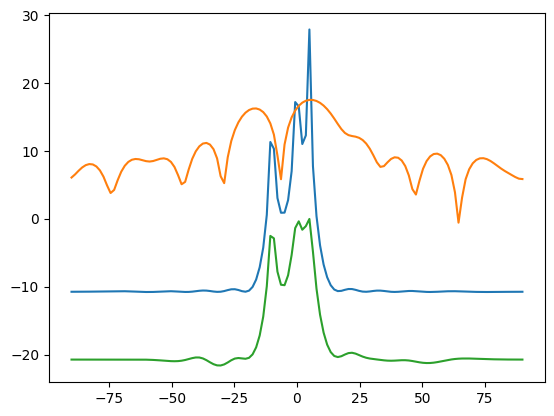

In [118]:
import numpy as np

# 清除变量，Python通常不需要这一步，但可以通过重启内核来清理环境
# 初始化参数
source_number = 3  # 信号源数量
sensor_number = 12  # 阵元数量
N_x = 256  # 信号长度
snapshot_number = N_x  # 快拍数
w = np.array([np.pi/4, np.pi/6, np.pi/8])  # 信号频率
l = np.sum(2 * np.pi * 3e8 / w) / 3  # 信号波长
d = 0.5 * l  # 阵元间距
snr = 10  # 信噪比

source_doa = np.array([-5, 0, 10])  # 信号的入射角度
source_number = source_doa.shape[0]
print(source_number)

# 阵列流型 (Steering matrix)
A = np.exp(-1j * np.outer(np.arange(sensor_number), d * 2 * np.pi * np.sin(np.radians(source_doa)) / l))

# 仿真信号
s = np.sqrt(10**(snr/10)) * np.exp(1j * np.outer(w, np.arange(N_x)))

# 加了高斯白噪声后的阵列接收信号
x = A @ s  + (1/np.sqrt(2)) * (np.random.randn(sensor_number, N_x) + 1j * np.random.randn(sensor_number, N_x))

print(x.shape)


# 使用FFT
fft_data = np.abs(np.fft.fftshift((np.fft.fft(x[:,0], 128))))

# 使用music
angles_music, music_spectrum = music_algorithm(x, source_number, sensor_number, 128)
# 使用capon解算
angles_capon, capon_spectrum = doa_capon(x, n=128)

plt.figure()
plt.plot(angles_music, music_spectrum)
plt.plot(angles_music, 10*np.log10(fft_data))
plt.plot(angles_music, capon_spectrum)
